## - Import Library

In [1]:
import warnings
warnings.filterwarnings('ignore')

import copy
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
from glob import glob

import torch
from torch import nn, optim
from torchvision import transforms, models
from torch_snippets import *
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary 
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from torch.utils.data import random_split

## - Pytorch version & Device

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 1.12.0
device: cuda


## - Parameters

In [3]:
# Data
data_path = './data/Hand Gesture Recognition' # Path of data
train_data_folder_path = os.path.join(data_path, 'train/train') # Train
test_data_folder_path = os.path.join(data_path, 'test/test') # Test
print('Train data folder path:', train_data_folder_path)
print('Test data folder path:', test_data_folder_path)

validation_split = 0.2

# Training
epochs = 5  # Train epochs
batch_size = 64  # Batch size

Train data folder path: ./data/Hand Gesture Recognition/train/train
Test data folder path: ./data/Hand Gesture Recognition/test/test


## - Build Pytorch Dataset & DataLoader

In [4]:
class_list = os.listdir(train_data_folder_path)
print('Class:', class_list)

Class: ['12', '17', '0', '7', '16', '1', '8', '15', '14', '19', '5', '11', '18', '10', '3', '9', '2', '6', '4', '13']


In [5]:
transforming = train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(40),              # resize shortest side
        transforms.CenterCrop(40),          # crop longest side
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [6]:
# Train  & data
train_data_dataset = datasets.ImageFolder(train_data_folder_path, transform=transforming)

torch.manual_seed(10)
valid_size = int(len(train_data_dataset) * validation_split)
train_size = int(len(train_data_dataset) - valid_size)
train_data_dataset, valid_data_dataset = random_split(train_data_dataset, [train_size, valid_size])
print('Train size:', len(train_data_dataset))
print('Valid size:', len(valid_data_dataset))

train_dataloader = DataLoader(train_data_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data_dataset, batch_size=batch_size, shuffle=True)

# Test data
test_data_dataset = datasets.ImageFolder(test_data_folder_path, transform=transforming)
print('Test size:', len(test_data_dataset))
test_dataloader = DataLoader(test_data_dataset, batch_size=batch_size, shuffle=False)

Train size: 14400
Valid size: 3600
Test size: 6000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


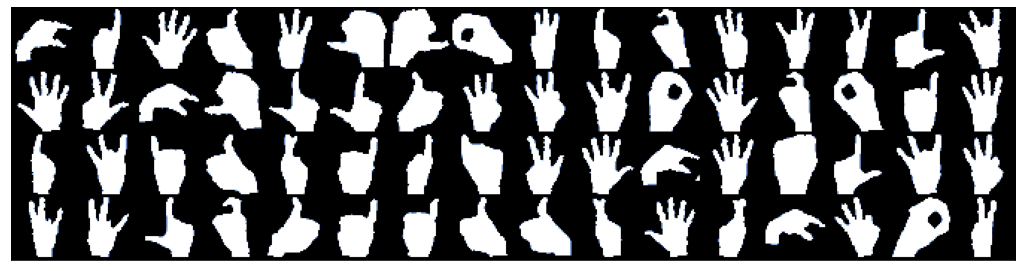

In [7]:
for images, labels in train_dataloader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

In [8]:
inspect(*next(iter(train_dataloader)), names='image, target')

IMAGE:
Tensor	Shape: torch.Size([64, 3, 40, 40])	Min: -2.118	Max: 2.640	Mean: -0.340	dtype: torch.float32 @ cpu
TARGET:
Tensor	Shape: torch.Size([64])	Min: 0.000	Max: 19.000	Mean: 9.641	dtype: torch.int64 @ cpu


## - Gesture Recognition with CNNs

In [9]:
class CNNGestureRecognizer(nn.Module):
    
    def __init__(self, class_num):
        super().__init__()
        self.network = nn.Sequential(
        nn.Conv2d(3, 100, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), 

        nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), 

        nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), 

        nn.Flatten(), 
        nn.Linear(6250, 256),  
        nn.ReLU(),            
        nn.Linear(256, 128),  
        nn.ReLU(),            
        nn.Linear(128, 64),           
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(32, class_num))
    
    def forward(self, x):
        x = self.network(x)
        return x

In [10]:
cnn_gesture_recognizer = CNNGestureRecognizer(len(class_list))
_ = summary(cnn_gesture_recognizer, torch.zeros(batch_size, 3, 40, 40).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 20]                  --
|    └─Conv2d: 2-1                       [-1, 100, 40, 40]         2,800
|    └─ReLU: 2-2                         [-1, 100, 40, 40]         --
|    └─Conv2d: 2-3                       [-1, 150, 40, 40]         135,150
|    └─ReLU: 2-4                         [-1, 150, 40, 40]         --
|    └─MaxPool2d: 2-5                    [-1, 150, 20, 20]         --
|    └─Conv2d: 2-6                       [-1, 200, 20, 20]         270,200
|    └─ReLU: 2-7                         [-1, 200, 20, 20]         --
|    └─Conv2d: 2-8                       [-1, 200, 20, 20]         360,200
|    └─ReLU: 2-9                         [-1, 200, 20, 20]         --
|    └─MaxPool2d: 2-10                   [-1, 200, 10, 10]         --
|    └─Conv2d: 2-11                      [-1, 250, 10, 10]         450,250
|    └─ReLU: 2-12                        [-1, 250, 10, 10]    

## - Train & Validate Model

In [11]:
def train(data, model, optimizer, loss_fn):
    
    # Set train
    model.train()
    
    # Get batch data
    imgs, targets = data
    imgs = imgs.to(device)
    targets = targets.to(device)
    
    # Inference
    outputs = model(imgs)
    
    # Get loss
    loss = loss_fn(outputs, targets)
    
    # Get class
    preds = outputs.argmax(-1)
    
    acc = (sum(preds==targets) / len(targets))
    
    # Init gradient
    model.zero_grad()
    
    # Backword propagation
    loss.backward()
    
    # Optimization 
    optimizer.step()
    
    return loss, acc

In [12]:
@torch.no_grad()
def validate(data, model, loss_fn):
    
    # Set valid
    model.eval()
    
    # Get batch data
    imgs, targets = data
    imgs = imgs.to(device)
    targets = targets.to(device)
    
    # Inference
    outputs = model(imgs)
    
    # Get loss
    loss = loss_fn(outputs, targets)
    
    # Get class
    preds = outputs.argmax(-1)
    
    acc = (sum(preds==targets) / len(targets))
    
    return loss, acc

In [13]:
log = Report(epochs)

# Convert to cuda
model = CNNGestureRecognizer(len(class_list)).to(device)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters())

# Gradient sceduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10,
                                     gamma=0.5)

In [14]:
for epoch in range(epochs):
    n_batch = len(train_dataloader)
    for i, data in enumerate(train_dataloader):
        train_loss, train_acc = train(data, model, 
                                      optimizer, loss_fn)
        pos = epoch + ((i+1)/n_batch)
        log.record(pos=pos, train_loss=train_loss, 
                   train_acc=train_acc, end='\r')
        
    n_batch = len(valid_dataloader)
    for i, data in enumerate(valid_dataloader):
        val_loss, val_acc = validate(data, model, loss_fn)
        pos = epoch + ((i+1)/n_batch)
        log.record(pos=pos, val_loss=val_loss, val_acc=val_acc, 
                   end='\r')
    
    scheduler.step()
    log.report_avgs(epoch+1)

EPOCH: 1.000	train_loss: 1.520	train_acc: 0.517	val_loss: 0.065	val_acc: 0.979	(16.61s - 66.46s remaining)
EPOCH: 2.000	train_loss: 0.110	train_acc: 0.964	val_loss: 0.005	val_acc: 0.999	(31.66s - 47.49s remaining)
EPOCH: 3.000	train_loss: 0.103	train_acc: 0.972	val_loss: 0.008	val_acc: 0.999	(46.10s - 30.73s remaining)
EPOCH: 4.000	train_loss: 0.054	train_acc: 0.983	val_loss: 0.049	val_acc: 0.989	(61.32s - 15.33s remaining)
EPOCH: 5.000	train_loss: 0.031	train_acc: 0.989	val_loss: 0.006	val_acc: 0.999	(75.86s - 0.00s remaining)


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 3322.82it/s]


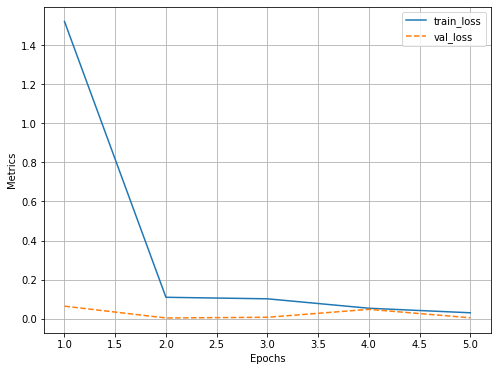

In [15]:
log.plot_epochs(['train_loss', 'val_loss'])

100%|███████████████████████████████████████| 106/106 [00:00<00:00, 3644.26it/s]


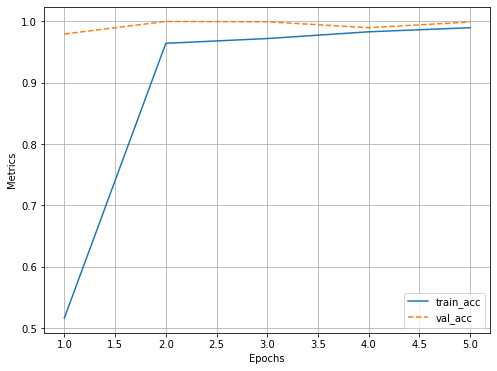

In [16]:
log.plot_epochs(['train_acc', 'val_acc'])

## - Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Targets: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Test preds: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


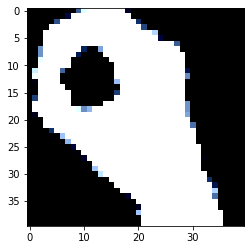

In [17]:
for data in iter(test_dataloader):
    imgs, targets = data
    imgs = imgs.to(device)
    targets = targets.to(device)
    
    outputs = model(imgs)
    test_preds = outputs.argmax(-1)
    print('Targets:', targets)
    print('Test preds:', test_preds)
    img = imgs.cpu()[0]
    plt.imshow(img.permute(1, 2, 0))
    
    break